In [1]:
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [3]:
                '''Parameters'''
### Parameters
num_data = 667
  
### Model Hyperparameters
w = 2000                 # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 300                # Prediction window (number of time stampes required to be 
                         # predicted)
num_features = 1           # grayscale image
num_category = 6
category_dict = {0 : 'UP_1-2F', 1: 'UP_3-4F', 2 : 'UP_5-7F', 3 : 'DOWN_1-2F', 4: 'DOWN_3-4F', 5 : 'DOWN_5-7F'}

kernel_size = 3          # Size of filter in conv layers
num_neuron_1 = 32        # Number of filters in first conv layer
num_neuron_2 = 32        # Number of filters in second conv layer
num_neuron_dl = 40       # Number of neurons in dense layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

num_epoch = 50
learning_rate = 2e-5  

In [4]:
                """Data loading"""
import requests
import shutil

data_value_dict = {}
data_label_dict = {}
max_length = 0
df_temp = pd.read_csv(r'C:\Users\A\Desktop\Classification\label.csv')


for i in range(0, num_data):
  
  
  
  im_array = np.load(r'C:\Users\A\Desktop\Classification\my_data\png/'+str(i)+'.npy', allow_pickle=True)
  data_value_dict[i] = im_array
  data_label_dict[i] = df_temp['Label'][i]
#print(data_label_dict)
  

In [5]:
                """Data preprocessing"""
# Map raw labels to each category
def is_up(label):
    return (label / 100 >= 1)
def is_0_2F(label):
    if (is_up(label)) :
      label = label - 100
    return (label / 10 < 3)
def is_3_4F(label):
    if (is_up(label)) :
      label = label - 100
    return (3 <= label / 10 < 5)

for i in range(0, num_data):
    label = data_label_dict[i]
    if is_up(label) :
        if is_0_2F(label) : data_label_dict[i] = 0
        elif is_3_4F(label) : data_label_dict[i] = 1
        else : data_label_dict[i] = 2
    else :
        if is_0_2F(label) : data_label_dict[i] = 3
        elif is_3_4F(label) : data_label_dict[i] = 4
        else : data_label_dict[i] = 5

In [6]:
# split into test and training set and convert data into array
test_ix = randint(1,num_data + 1)
X_test, y_test, X_train, y_train = list(), list(), list(), list()
for i in range(1, num_data) :
  if(i != test_ix):
    X_train.append(data_value_dict[i])
    y_train.append(data_label_dict[i])
  else :
    X_test.append(data_value_dict[i])
    y_test.append(data_label_dict[i])
X_train = array(X_train)
y_train = array(y_train)
X_test = array(X_test)
y_test = array(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], num_features)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], num_features)

# reformat array
X_train_reshaped = X_train_reshaped.astype('float32')
X_test_reshaped = X_test_reshaped.astype('float32')
X_train_reshaped /= 255
X_test_reshaped /= 255
print('X_train_reshaped shape:', X_train_reshaped.shape) #X_train shape: (60000, 28, 28, 1)
print('X_test_reshaped shape:', X_test_reshaped.shape) #X_test shape: (60000, 28, 28, 1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

(665, 400, 600) (665,) (1, 400, 600) (1,)
X_train_reshaped shape: (665, 400, 600, 1)
X_test_reshaped shape: (1, 400, 600, 1)


In [7]:
                 '''Model building'''
model = Sequential()
model.add(Conv2D(24, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2], num_features)))
model.add(Conv2D(24, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_category, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 398, 598, 24)      240       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 396, 596, 24)      5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 198, 298, 24)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1416096)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                42482910  
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

In [8]:
                 '''configure model'''
model.compile(optimizer='adam', 
              loss=keras.losses.categorical_crossentropy,
              metrics=["accuracy"])

# sgd = keras.optimizers.SGD(lr=learning_rate, 
#                          decay=1e-6, 
#                          momentum=0.9, 
#                          nesterov=True)
# model.compile(optimizer='sgd', 
#               loss='mean_absolute_error', 
#               metrics=['accuracy'])

In [9]:
                    '''Training'''
model_log = model.fit(X_train_reshaped, y_train,
                      batch_size=64,
                      epochs=num_epoch,
                      verbose=1,
                      validation_data=(X_test_reshaped, y_test))

Train on 665 samples, validate on 1 samples
Epoch 1/50
665/665 [==============================] - 106s 159ms/step - loss: 12.4356 - accuracy: 0.1955 - val_loss: 1.7828 - val_accuracy: 1.0000
Epoch 2/50
665/665 [==============================] - 105s 158ms/step - loss: 1.7886 - accuracy: 0.2917 - val_loss: 1.7739 - val_accuracy: 1.0000
Epoch 3/50
665/665 [==============================] - 109s 163ms/step - loss: 1.7857 - accuracy: 0.2917 - val_loss: 1.7640 - val_accuracy: 1.0000
Epoch 4/50
665/665 [==============================] - 108s 163ms/step - loss: 2.7322 - accuracy: 0.2962 - val_loss: 1.7533 - val_accuracy: 1.0000
Epoch 5/50
665/665 [==============================] - 107s 161ms/step - loss: 1.7014 - accuracy: 0.4677 - val_loss: 1.4338 - val_accuracy: 1.0000
Epoch 6/50
665/665 [==============================] - 106s 159ms/step - loss: 1.2089 - accuracy: 0.6977 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 7/50
665/665 [==============================] - 106s 159ms/step - loss: 0

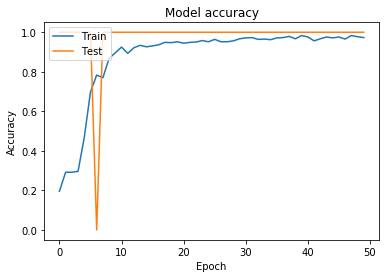

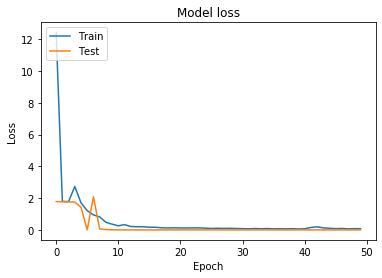

In [10]:
# Plot training & validation accuracy values
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
               """Save Weights (DeepAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('elevator_2D_CNN_1.h5') 

1/1 [==============================] - 0s 58ms/step
[[0. 0. 0. 1. 0. 0.]]
[0. 0. 0. 1. 0. 0.]


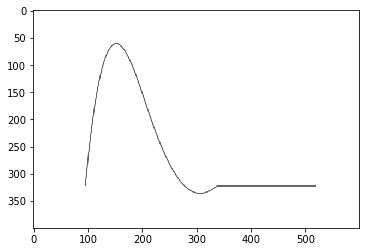

In [13]:
            """Classifying test sequence""" 
# Build model 
model = Sequential()
model.add(Conv2D(24, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2], num_features)))
model.add(Conv2D(24, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_category, activation='softmax'))

# Load the model's saved weights.
model.load_weights('elevator_2D_CNN_1.h5')

# Predict the next time stampes of the sampled sequence
ix = 10
sample = array(data_value_dict[ix])
plt.imshow(sample, cmap='gray', vmin=0, vmax=255)
plt.show
sample = sample.reshape(1, sample.shape[0], sample.shape[1], num_features)

yhat = model.predict(sample, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(keras.utils.to_categorical(data_label_dict[ix], num_category)) # [7, 2, 1, 0, 4]